Copyright 2018 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

# Evaluation code


__Disclaimer__
*   This notebook contains experimental code, which may be changed without notice.
*   The ideas here are some ideas relevant to fairness - they are not the whole story!



# Notebook summary

This notebook intends to evaluate a list of models on two dimensions:
- "Performance": How well the model perform to classify the data (intended bias). Currently, we use the AUC.
- "Bias": How much bias does the model contain (unintended bias). Currently, we use the pinned auc.

This script takes the following steps:

- Write input function to generate 2 datasets:
    - a "performance dataset" which will be used for the first set of metrics. This dataset is supposed to be similar format to the training data (contain a text and a label).
    - a "bias dataset" which will be used for the second set of metrics. This data contains a text, a label but also some subgroup information to evaluate the unintended bias on.
- Runs predictions with the export_utils.
- Evaluate metrics.

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import getpass
import json
import nltk
import numpy as np
import pandas as pd
import pkg_resources
import os
import random
import re
import seaborn as sns

# import googleapiclient.discovery as discovery
# import googleapiclient.errors as errors
import tensorflow as tf
from tensorflow.python.lib.io import file_io

/usr/local/google/home/fprost/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
from utils_export.dataset import Dataset, Model
from utils_export import utils_cloudml

In [5]:
os.environ['GCS_READ_CACHE_MAX_SIZE_MB'] = '0' #Faster to access GCS file + https://github.com/tensorflow/tensorflow/issues/15530

# Settings

### Global variables

In [6]:
# User inputs
PROJECT_NAME = 'wikidetox'

# Information about deployed model.
MODEL_NAMES = ['tf_gru_attention:v_20180823_133625']
TEXT_FEATURE_NAME = 'comment_text' #Input text
SENTENCE_KEY = 'comment_key' #Input key
LABEL_NAME_PREDICTION_MODEL = 'frac_neg/logistic' # Output prediction

# Part 1: Creating input_fn

In [7]:
def tokenizer(text, lowercase=True):
  """Converts text to a list of words.

  Args:
    text: text to tokenize (string).
    lowercase: whether to include lowercasing in preprocessing (boolean).
    tokenizer: Python function to tokenize the text on.

  Returns:
    A list of strings (words).
  """
  words = nltk.word_tokenize(text.decode('utf-8'))
  if lowercase:
    words = [w.lower() for w in words]
  return words

### Performance dataset

In [8]:
# User inputs
PERFORMANCE_DATASET = 'gs://kaggle-model-experiments/resources/toxicity_q42017_test.tfrecord'
LABEL_NAME_TEST_FILE = 'frac_neg' #Name of the label in the performance dataset

In [9]:
def create_input_fn(tf_records_path, text_feature_name, label_name):
                    
  def load_tf_records_to_pandas(max_n_examples=None, random_filter_keep_rate=1.0):
      '''Loads tf-records into a pandas dataframe.'''

      if not max_n_examples:
        max_n_examples = float('inf')

      # Read TFRecord file
      reader = tf.TFRecordReader()
      filename_queue = tf.train.string_input_producer([tf_records_path], num_epochs=1)

      _, serialized_example = reader.read(filename_queue)

      # Define features
      read_features = {
          text_feature_name: tf.FixedLenFeature([], dtype=tf.string),
          label_name: tf.FixedLenFeature([], dtype=tf.float32)
      }

      # Extract features from serialized data
      read_data = tf.parse_single_example(serialized=serialized_example,
                                          features=read_features)

      # Read and print data:
      sess = tf.InteractiveSession()

      # Many tf.train functions use tf.train.QueueRunner,
      # so we need to start it before we read.
      sess.run(tf.global_variables_initializer())
      sess.run(tf.local_variables_initializer())
      sess.run(tf.tables_initializer())
      tf.train.start_queue_runners(sess)

      d = []
      new_line = sess.run(read_data)
      count = 0
      while new_line:
        if random.random() < random_filter_keep_rate:
            d.append(new_line)
            count += 1
            if count >= max_n_examples:
              break
            if not(count % 100000):
              print ('Loaded {} lines.'.format(count))
        try:
          new_line = sess.run(read_data)
        except tf.errors.OutOfRangeError:
          print ('End of file.')
          break
        
      res = pd.DataFrame(d)
      res[text_feature_name] = list(map(tokenizer, res[text_feature_name]))
      
      return res

  return load_tf_records_to_pandas

### Bias dataset

In [10]:
!pip install -U -q git+https://github.com/conversationai/unintended-ml-bias-analysis

google-cloud-pubsub 0.26.0 has requirement google-cloud-core<0.26dev,>=0.25.0, but you'll have google-cloud-core 0.28.1 which is incompatible.
google-gax 0.15.15 has requirement grpcio<1.6dev,>=1.0.2, but you'll have grpcio 1.11.0 which is incompatible.
apache-beam 2.1.1 has requirement httplib2<0.10,>=0.8, but you'll have httplib2 0.11.3 which is incompatible.
apache-beam 2.1.1 has requirement protobuf<=3.3.0,>=3.2.0, but you'll have protobuf 3.5.2 which is incompatible.
apache-beam 2.1.1 has requirement six<1.11,>=1.9, but you'll have six 1.11.0 which is incompatible.
tensorboard 1.8.0 has requirement bleach==1.5.0, but you'll have bleach 2.1.3 which is incompatible.
tensorboard 1.8.0 has requirement html5lib==0.9999999, but you'll have html5lib 1.0.1 which is incompatible.
tensorflow-gpu 1.2.1 has requirement bleach==1.5.0, but you'll have bleach 2.1.3 which is incompatible.
tensorflow-gpu 1.2.1 has requirement html5lib==0.9999999, but you'll have html5lib 1.0.1 which is incompatibl

In [11]:
from unintended_ml_bias import model_bias_analysis

In [12]:
# Loading it from it the unintended_ml_bias github.
entire_test_bias_df = pd.read_csv(
    pkg_resources.resource_stream("unintended_ml_bias", "eval_datasets/bias_madlibs_77k.csv"))
entire_test_bias_df['raw_text'] = entire_test_bias_df['Text']
entire_test_bias_df['label'] = entire_test_bias_df['Label']
entire_test_bias_df['label'] = list(map(lambda x: x=='BAD', entire_test_bias_df['label']))
entire_test_bias_df = entire_test_bias_df[['raw_text', 'label']].copy()
terms = [line.strip()
         for line in pkg_resources.resource_stream("unintended_ml_bias", "bias_madlibs_data/adjectives_people.txt")]
model_bias_analysis.add_subgroup_columns_from_text(entire_test_bias_df, 'raw_text', terms)
# Add preprocessing
entire_test_bias_df['text'] = list(map(tokenizer, entire_test_bias_df['raw_text']))

In [13]:
def input_fn_bias(max_n_examples):
    if max_n_examples:
        res = entire_test_bias_df.sample(n=max_n_examples, random_state=2018)
    else:
        res = entire_test_bias_df
    res = res.copy(deep=True)
    res = res.rename(
        columns={
            'raw_text': TEXT_FEATURE_NAME
        })
    return res

# Part 2: Running prediction

### Defining the model

In [14]:
# User inputs.
model_input_spec = {
    TEXT_FEATURE_NAME: utils_cloudml.FeatureSpec.LIST_STRING} #library will use this automatically

model = Model(
    feature_keys_spec=model_input_spec,
    prediction_keys=LABEL_NAME_PREDICTION_MODEL,
    example_key=SENTENCE_KEY,
    model_names=MODEL_NAMES,
    project_name=PROJECT_NAME)

### Performance dataset

In [15]:
# User inputs
SIZE_PERFORMANCE_DATA_SET = 10000

# Pattern for path of tf_records
TF_RECORD_PERFORMANCE_PATTERN = os.path.join(
    'gs://kaggle-model-experiments/',
    getpass.getuser(),
    'tfrecords/test_performance')

In [16]:
input_fn_performance = create_input_fn(PERFORMANCE_DATASET, TEXT_FEATURE_NAME, LABEL_NAME_TEST_FILE)
dataset_performance = Dataset(input_fn_performance)
dataset_performance.load_data(SIZE_PERFORMANCE_DATA_SET, random_filter_keep_rate=0.5)

INFO:tensorflow:input_fn is compatible with the `Dataset` class.


/usr/local/google/home/fprost/anaconda2/lib/python2.7/site-packages/tensorflow/python/client/session.py:1711: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [17]:
dataset_performance.add_model_prediction_to_data(model, tf_record_path_pattern=TF_RECORD_PERFORMANCE_PATTERN)

INFO:tensorflow:Model is compatible with the `Dataset` instance.
INFO:tensorflow:Preparing train data: 0/10000


/usr/local/google/home/fprost/anaconda2/lib/python2.7/site-packages/google/auth/_default.py:66: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/.
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


INFO:tensorflow:state : QUEUED
INFO:tensorflow:Waiting for prediction job to complete. Minutes elapsed: 0.0
INFO:tensorflow:Waiting for prediction job to complete. Minutes elapsed: 2.5
INFO:tensorflow:Waiting for prediction job to complete. Minutes elapsed: 5.0
INFO:tensorflow:Prediction job completed.


### Bias dataset

In [18]:
# User inputs
SIZE_PERFORMANCE_DATA_SET = None

# Pattern for path of tf_records
TF_RECORD_BIAS_PATTERN = os.path.join(
    'gs://kaggle-model-experiments/',
    getpass.getuser(),
    'tfrecords/bias_performance')

In [19]:
dataset_bias = Dataset(input_fn_bias)
dataset_bias.load_data(SIZE_PERFORMANCE_DATA_SET)

INFO:tensorflow:input_fn is compatible with the `Dataset` class.


In [21]:
dataset_bias.add_model_prediction_to_data(model, tf_record_path_pattern=TF_RECORD_BIAS_PATTERN)

INFO:tensorflow:Model is compatible with the `Dataset` instance.
INFO:tensorflow:Preparing train data: 0/76564
INFO:tensorflow:Preparing train data: 10000/76564
INFO:tensorflow:Preparing train data: 20000/76564
INFO:tensorflow:Preparing train data: 30000/76564
INFO:tensorflow:Preparing train data: 40000/76564
INFO:tensorflow:Preparing train data: 50000/76564
INFO:tensorflow:Preparing train data: 60000/76564
INFO:tensorflow:Preparing train data: 70000/76564
INFO:tensorflow:state : QUEUED
INFO:tensorflow:Waiting for prediction job to complete. Minutes elapsed: 0.0
INFO:tensorflow:Waiting for prediction job to complete. Minutes elapsed: 2.5
INFO:tensorflow:Waiting for prediction job to complete. Minutes elapsed: 5.0
INFO:tensorflow:Prediction job completed.


### Post processing

In [30]:
# Setting the table to match the required format.
test_performance_df = dataset_performance.show_data()
test_performance_df = test_performance_df.rename(
    columns={
        TEXT_FEATURE_NAME: 'raw_text',
        LABEL_NAME_TEST_FILE: 'label'
    })
test_performance_df['label'] = list(map(lambda x :bool(round(x)), list(test_performance_df['label'])))

In [23]:
test_bias_df = dataset_bias.show_data()

### Analyzing final results

In [24]:
test_performance_df.head()

,raw_text,label,tf_gru_attention:v_20180823_133625
0,"[``, the, tank, losses, extremely, biased, the...",False,0.427523
1,"[sandifer, ,, i, 'm, going, buy, my, way, back...",True,0.320056
2,"[support, per, nom, ., talk]",False,0.290629
3,"[``, we, do, n't, keep, non-free, material, ju...",False,0.331023
4,"[unblock, and, thanks, ,]",False,0.289773


In [25]:
test_bias_df.head()

,comment_text,label,lesbian,gay,bisexual,transgender,trans,queer,lgbt,lgbtq,...,younger,teenage,millenial,middle aged,elderly,blind,deaf,paralyzed,text,tf_gru_attention:v_20180823_133625
0,murder american,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,"[murder, american]",0.438511
1,respect trans,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,"[respect, trans]",0.447293
2,respect homosexual,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,"[respect, homosexual]",0.428770
3,hug mexican,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,"[hug, mexican]",0.444693
4,kill sikh,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,"[kill, sikh]",0.429989


# Part 3: Run evaluation metrics

In [26]:
MODEL_FAMILIES = [MODEL_NAMES]

## Performance metrics

### Data Format

At this point, our performance data is in DataFrame df, with columns:

text: Full text of the comment.
label: True if the comment is Toxic, False otherwise.
< model name >: One column per model, cells contain the score from that model.
You can run the analysis below on any data in this format. Subgroup labels can be generated via words in the text as done above, or come from human labels if you have them.

### Run AUC

In [27]:
import sklearn.metrics as metrics

In [31]:
for model_family in MODEL_FAMILIES:
  auc_list = []
  for model in model_family:
    fpr, tpr, thresholds = metrics.roc_curve(
        test_performance_df['label'],
        test_performance_df[model])
    auc_list.append(metrics.auc(fpr, tpr))
  print ('Auc for model {}: {}'.format(model, np.mean(auc_list)))

Auc for model tf_gru_attention:v_20180823_133625: 0.406235508997


## Unintended Bias Metrics

### Data Format
At this point, our bias data is in DataFrame df, with columns:

*   label: True if the comment is Toxic, False otherwise.
*   < model name >: One column per model, cells contain the score from that model.
*   < subgroup >: One column per identity, True if the comment mentions this identity.

You can run the analysis below on any data in this format. Subgroup labels can be 
generated via words in the text as done above, or come from human labels if you have them.


### Pinned AUC
Pinned AUC measures the extent of unintended bias of a real-value score function
by measuring each sub-group's divergence from the general distribution.

Let $D$ represent the full data set and $D_g$ be the set of examples in subgroup
$g$. Then:


$$ Pinned \ dataset \ for \ group \ g = pD_g = s(D_g) + s(D), |s(D_g)| = |s(D)| $$

$$ Pinned \ AUC \ for \ group \ g = pAUC_g = AUC(pD_g) $$

$$ Pinned \ AUC \ Squared \ Equality \ Difference = \Sigma_{g \in G}(AUC - pAUC_g)^2 $$


### Pinned AUC Equality Difference
The table below shows the pinned AUC equality difference for each model family.
Lower scores (lighter red) represent more similarity between each group's pinned AUC, which means
less unintended bias.

On this set, the wiki_debias_cnn model demonstrates least unintended bias. 

In [32]:
cm = sns.light_palette("red", as_cmap=True)

In [33]:
eq_diff = model_bias_analysis.per_subgroup_auc_diff_from_overall(
    test_bias_df, terms, MODEL_FAMILIES, squared_error=True, normed_auc=True)
# sort to guarantee determi7nistic output
eq_diff.sort_values(by=['model_family'], inplace=True)
eq_diff.reset_index(drop=True, inplace=True)
eq_diff.style.background_gradient(cmap=cm)

,model_family,pinned_auc_equality_difference
0,tf_gru_attention:v_20180823_133625,0.00865119


### Pinned AUC Graphs
The graphs below show per-group Pinned AUC for each subgroup and each model. Each
identity group shows 3 points, each representing the pinned AUC for one training 
version of the model. More consistency among the values represents less unintended bias.

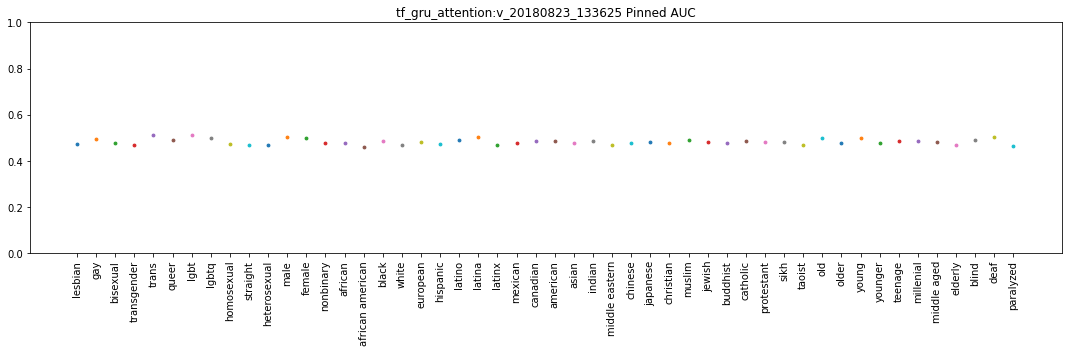

In [34]:
pinned_auc_results = model_bias_analysis.per_subgroup_aucs(test_bias_df, terms, MODEL_FAMILIES, 'label')
for family in MODEL_FAMILIES:
  name = model_bias_analysis.model_family_name(family)
  model_bias_analysis.per_subgroup_scatterplots(
      pinned_auc_results,
      'subgroup',
      name + '_aucs',
      name + ' Pinned AUC',
      y_lim=(0., 1.0))